# Detectron2 Custom Training Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2!

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

     |████████████████████████████████| 274 kB 5.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ec3c4483a7b00bf1510cf0d55805aad575016ddc50c866beb9acec5bb1a03d62
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.10.0+cu111 True


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.9")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 938 kB/s 
     |████████████████████████████████| 130 kB 7.2 MB/s 
     |████████████████████████████████| 145 kB 35.8 MB/s 
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
     |████████████████████████████████| 843 kB 48.8 MB/s 
     |████████████████████████████████| 749 kB 37.7 MB/s 
     |████████████████████████████████| 112 kB 48.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=df346a8f8b79233f8692cfdf8dd3d7bbb94f5b1158691ab85a337f628c9c1916
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=1eca8ceda855324a74d806972c8b9ebed3

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/detectron2

/content/drive/MyDrive/detectron2


In [ ]:
!unzip data_detectron2.zip

Archive:  data_detectron2.zip
replace data_detectron2/output.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%cd data_detectron2

/content/drive/MyDrive/detectron2/data_detectron2


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain1", {}, "./output.json", "./train")

In [ ]:
sample_metadata = MetadataCatalog.get("customtrain1")
dataset_dicts = DatasetCatalog.get("customtrain1")

WARNING [04/02 07:11:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/02 07:11:27 d2.data.datasets.coco]: Loaded 290 images in COCO format from ./output.json


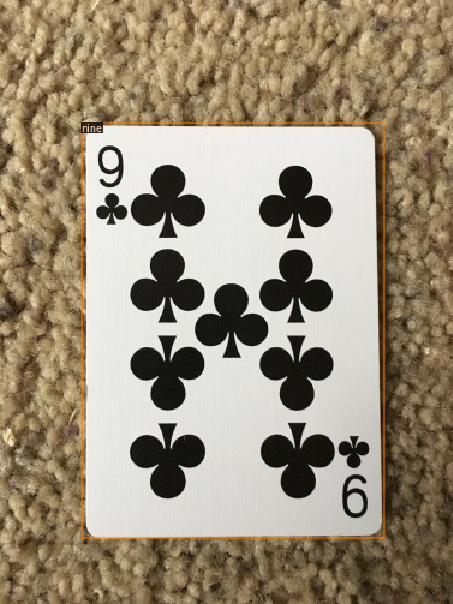

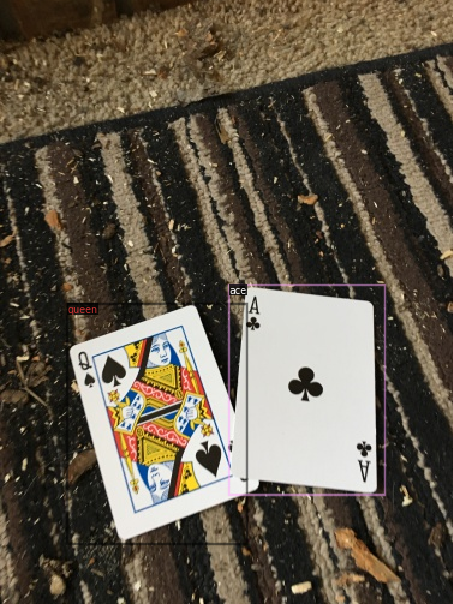

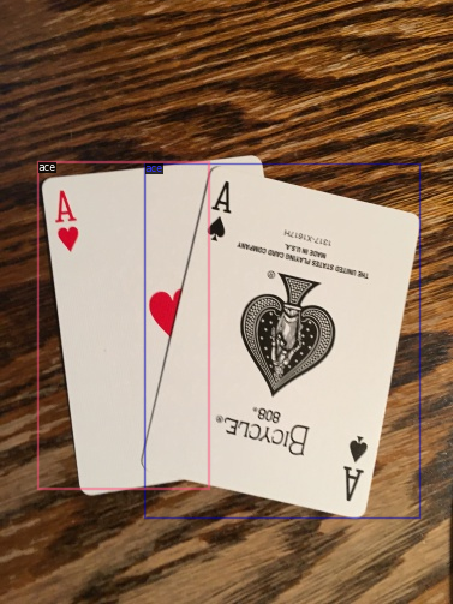

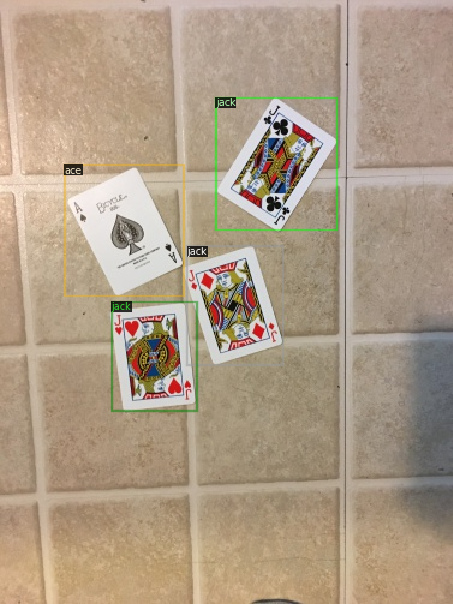

In [ ]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 700    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[04/02 07:37:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:02, 56.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[04/02 07:37:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/02 07:37:48 d2.utils.events]:  eta: 0:13:39  iter: 19  total_loss: 2.524  loss_cls: 1.768  loss_box_reg: 0.7078  loss_rpn_cls: 0.003274  loss_rpn_loc: 0.006028  time: 1.2117  data_time: 0.0290  lr: 7.0289e-05  max_mem: 2641M
[04/02 07:38:13 d2.utils.events]:  eta: 0:13:18  iter: 39  total_loss: 1.487  loss_cls: 0.79  loss_box_reg: 0.6729  loss_rpn_cls: 0.002044  loss_rpn_loc: 0.003189  time: 1.2160  data_time: 0.0078  lr: 0.00014165  max_mem: 2641M
[04/02 07:38:37 d2.utils.events]:  eta: 0:12:53  iter: 59  total_loss: 1.286  loss_cls: 0.5725  loss_box_reg: 0.7228  loss_rpn_cls: 0.002516  loss_rpn_loc: 0.004269  time: 1.2238  data_time: 0.0075  lr: 0.000213  max_mem: 2641M
[04/02 07:39:02 d2.utils.events]:  eta: 0:12:30  iter: 79  total_loss: 1.279  loss_cls: 0.5406  loss_box_reg: 0.7148  loss_rpn_cls: 0.003325  loss_rpn_loc: 0.002601  time: 1.2203  data_time: 0.0071  lr: 0.00028436  max_mem: 2641M
[04/02 07:39:27 d2.utils.events]:  eta: 0:12:06  iter: 99  total_loss: 1.356  loss_cl

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain1", )
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


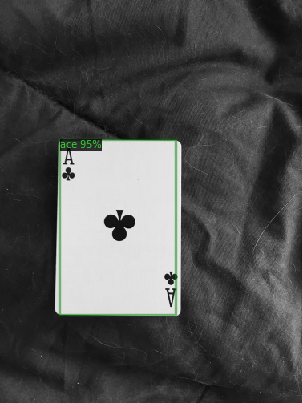

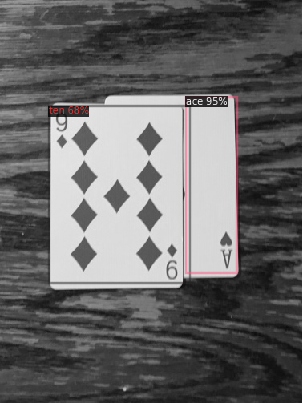

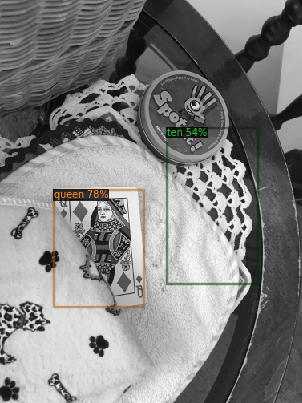

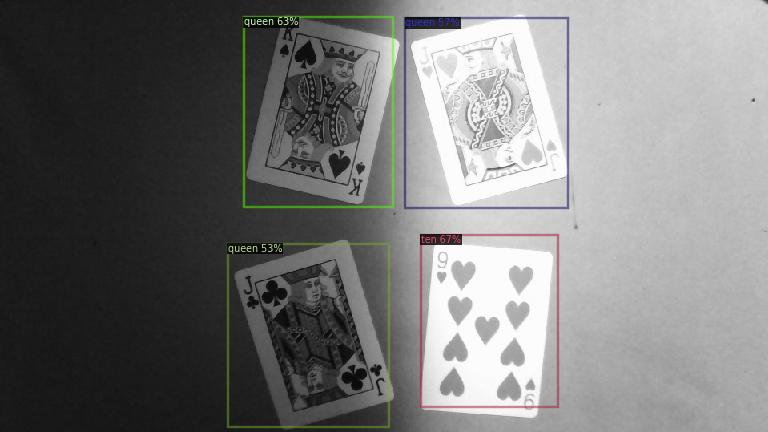

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

### Getting the custom config file

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()